## In this homework, we extract timeseries from plastic data for each object and each band and train autoencoder neural network (NN) and extract features from bottleneck layer (hidden layer) and add them to previously calculated features (HW7) and check whether adding these new features improve the model using Random forest.

In [0]:
# Author : P. Mondal
# Date : 09 May, 2020

In [2]:
import pandas as pd
import numpy as np
import pylab as pl

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [3]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [4]:
from google.colab import drive

drive.mount("/content/gdrive")
%cd gdrive/My\ Drive
%ls *.npy

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
featureshw5.npy  featureshw5_v2.npy


# Data preparation


**First task is to obtain time series for each object for each band**

In [5]:
%cd MLTSA2020


/content/gdrive/My Drive/MLTSA2020


In [6]:
# this is not a reproducible way to do it!

lcvs = pd.read_csv("data/plasticc_train_lightcurves.csv")

# The Zenodo data include 1.4 million datapoints. 
## -- I am subsampling the data to develop the code 
# by using only the first 10000 datapoints (lcvs[:10000])
## -- When I am done I will run this on the larger dataset (commenting out #[:10000])
## note that I am choosing the first N=1000, as opposed to 1 every 100 or whatever 
## because there are 6 time series per obects in 6 filters (colors)

lcvs = lcvs#[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)


The dataset contains: (observations, columns) (1421705, 6)


In [7]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [8]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [9]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


## Find mjd for each object and each filter!

In [10]:
print(lcvs.shape)
lcvs.shape[0]/(7848*6)
7848*6
len(objects)

(1421705, 6)


7848

In [11]:
lcvs.object_id

0                615
1                615
2                615
3                615
4                615
             ...    
1421700    130779836
1421701    130779836
1421702    130779836
1421703    130779836
1421704    130779836
Name: object_id, Length: 1421705, dtype: int64

**Extract time series for each object and each filter**

In [12]:
"""
data_lcvs = np.zeros((len(objects), len(bands), 60, 2), dtype=object) 
count = 0
for obj1 in objects:
  for band in bands:
    
    lcvs_2 = pd.DataFrame()
    lcvs_3 = pd.DataFrame()
    lcvs_2 = lcvs[lcvs.object_id==obj1]
    lcvs_3 = lcvs_2[lcvs_2.passband==band]
    
    # Save only "flux" and "mjd"
    data_lcvs[obj1][band][:,0] = lcvs_3.flux.values
    data_lcvs[obj1][band][:,1] = lcvs_3.mjd.values - lcvs_3.mjd.values[0]

    count = count +1 
    # Save only "flux" and "mjd"
print('Number of data', count)
"""

'\ndata_lcvs = np.zeros((len(objects), len(bands), 60, 2), dtype=object) \ncount = 0\nfor obj1 in objects:\n  for band in bands:\n    \n    lcvs_2 = pd.DataFrame()\n    lcvs_3 = pd.DataFrame()\n    lcvs_2 = lcvs[lcvs.object_id==obj1]\n    lcvs_3 = lcvs_2[lcvs_2.passband==band]\n    \n    # Save only "flux" and "mjd"\n    data_lcvs[obj1][band][:,0] = lcvs_3.flux.values\n    data_lcvs[obj1][band][:,1] = lcvs_3.mjd.values - lcvs_3.mjd.values[0]\n\n    count = count +1 \n    # Save only "flux" and "mjd"\nprint(\'Number of data\', count)\n'

In [243]:
"""
data_lcvs = np.zeros((len(objects), len(bands), 60, 2), dtype=object) 

print(data_lcvs[0][0][:,1].shape)
t_len = np.zeros((len(objects)*len(bands)), dtype=float64)
objects[0]
lcvs_2 = lcvs[lcvs.object_id==obj1][lcvs.passband==band]
"""

(60,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [12]:
"""
print(lcvs.shape)
# Get shape of time series of each object and each passband
t_len = np.zeros((len(objects), len(bands)), dtype=float64)

for ii in range(1):#len(objects)):
  # print(ii)
  obj1 = objects[ii]
  for jj in range(1):#(len(bands)):
    band = bands[jj]
    lcvs_2 = pd.DataFrame()
    lcvs_2 = lcvs[lcvs.object_id==obj1][lcvs.passband==band]
    # Calculate mjd in days
    lcvs_day = floor(lcvs_2.mjd.values - lcvs_2.mjd.values[0])  
    print(lcvs_day.shape[0])
    # For each object and each band find length of time series
    t_len[ii, jj] = lcvs_day.shape[0]

"""

(1421705, 6)
58


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# lcvs_day

array([  0.,   1.,  16.,  19.,  28.,  31.,  46.,  49.,  56.,  59.,  62.,
        84.,  88.,  91., 103., 106., 113., 116., 119., 122., 133., 136.,
       373., 402., 411., 414., 417., 430., 433., 443., 446., 457., 460.,
       470., 473., 476., 486., 489., 498., 739., 742., 757., 781., 784.,
       787., 795., 798., 816., 823., 826., 829., 842., 845., 852., 855.,
       858., 870., 873.])

In [14]:
# Find max and min of time -series length
# print('maximum and minimum length of time series in dataset are :\n', amax(t_len), amin(t_len))


maximum and minimum length of time series in dataset are :
 58.0 0.0


In [76]:
"""
lcvs_days = (lcvs_2.mjd.values - lcvs_2.mjd.values[0])
floor(lcvs_days)
plot(lcvs_days)
"""

'\nlcvs_days = (lcvs_2.mjd.values - lcvs_2.mjd.values[0])\nfloor(lcvs_days)\nplot(lcvs_days)\n'

In [261]:
# type(int(amax(t_len)))

int

In [0]:
"""
flux_data = np.zeros((len(objects), len(bands), int(amax(t_len))), dtype=float64)
flux_data[:] = np.NaN
# flux_data
"""

In [14]:
# For each object and each band, we want to have data of maximum 900 consecutive
# days of observations from day 0

# Filled the flux_data array with flux value from the days of observations
# i.e. say 3rd observation of  ii^th object at jj^th band was done on Day 15, 
# then flux_data[ii][jj][15] = lcvs_flux[3]

max_day = 900
flux_data = np.zeros((len(objects), len(bands), max_day), dtype=float64)
flux_data[:] = np.NaN

for ii in range(len(objects)):
  # print(ii)
  obj1 = objects[ii]
  for jj in range(len(bands)):
    band = bands[jj]
    lcvs_2 = pd.DataFrame()
    # Create a new dataframe for each object and each band
    lcvs_2 = lcvs[lcvs.object_id==obj1][lcvs.passband==band]
    # Calculate mjd in days and set first day as 0 
    lcvs_days = np.zeros((len(lcvs_2.mjd.values)), dtype=float64)

    lcvs_days = (lcvs_2.mjd.values - lcvs_2.mjd.values[0])
    lcvs_flux = lcvs_2.flux.values
    # print(len(lcvs_days))
    #print(lcvs_flux)
    # print(lcvs_flux.shape)
    # Save flux value at those day index
    for item in range(len(lcvs_days)):
       # print(item, lcvs_days.shape)
       # Which day of observation
       it = lcvs_days[item]
       # print(it)
       if int(it) < max_day:
         flux_data[ii][jj][int(it)] = lcvs_flux[item] 
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


Use interpolation to fill in the nan values in flux_data

In [0]:
# Convert the array to dataframe
# Each column is a timeseries of an object at a specific band.
# The column names are organized as : object, band

data_nw = pd.DataFrame()
data_nw['Days'] = np.arange(max_day)
data_nw.head()

for ii in range(len(objects)):
  # print(ii)
  obj1 = objects[ii]
  for jj in range(len(bands)):
    band = bands[jj]
    lvl = str(obj1) + ', ' + str(band)
    data_nw[lvl] = flux_data[ii][jj]

**The dataframe data_nw is really big
Do not use data_nw.head()**

Used interpolation to fill in nan values so that all timeseries are evenly sampled.


In [0]:
data_nw2 = data_nw.interpolate()

In [17]:
print(data_nw2.shape)
print(data_nw2.columns)

(900, 47089)
Index(['Days', '615, 2', '615, 1', '615, 3', '615, 4', '615, 5', '615, 0',
       '713, 2', '713, 1', '713, 3',
       ...
       '130772921, 3', '130772921, 4', '130772921, 5', '130772921, 0',
       '130779836, 2', '130779836, 1', '130779836, 3', '130779836, 4',
       '130779836, 5', '130779836, 0'],
      dtype='object', length=47089)


Let us visualize out interpolated data

findfont: Font family ['Computer Modern Roman'] not found. Falling back to DejaVu Sans.


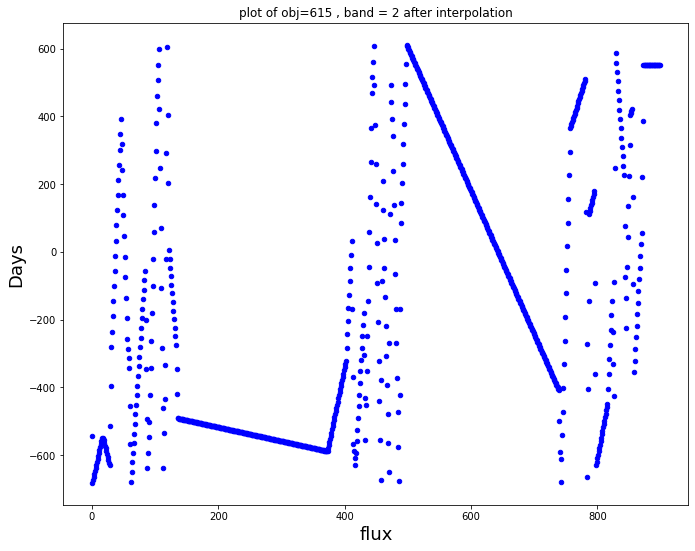

In [18]:

data_nw2.plot(x='Days', y='615, 2', kind='scatter', color='blue', figsize=(10,8))
pl.title('plot of obj=615 , band = 2 after interpolation')

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 12
  

pl.rc('font', size=SMALL_SIZE)          # controls default text sizes
  # pl.title("Correlation")  
pl.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
pl.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
pl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pl.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
axis_font = {'fontname':'Computer Modern Roman', 'size':'18'}
pl.xlabel("flux", **axis_font)
pl.ylabel("Days", **axis_font)
pl.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
pl.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  

pl.tight_layout()

Fig: The figure above shows a time series for object 615 at passband 2 after missing data were filled in using interpolation. One may see that interpolation did a bad fit when there is large data gap such as between 0 to 400 or 500 to 800. 


In [0]:
# Save prepared data
# data_nw2.to_csv('data_intrpltn.csv', index=False) 

## Prepare input features for autoencoder 
         input = t1|t2|t3|t4....f1|f2|f3|f4

In [368]:
"""
data_nw2.columns[1:2]
num_tm_srs = (data_nw2.shape[1]) 
Day_input = (data_nw2.iloc[:,0].values).T
Day_input.shape[0]

X_input = (data_nw2.iloc[:,1:num_tm_srs].values).T
X_input.shape
"""

(47088, 900)

In [19]:
# Converting entire time series dataframe into 2D array
# We are considering time i.e. 'Days' column as input feature too. 

# Total no. of observation days
num_tm_srs = (data_nw2.shape[1])
# Day from 0th day of observations 
Day_input = (data_nw2.iloc[:,0].values).T
# Flux input for each object and filter
X_input = (data_nw2.iloc[:,1:num_tm_srs].values).T

# Total no. of timestamps
col_t = Day_input.shape[0]
# Total no. of columns for NN input
col_f = col_t + X_input.shape[1]

# Total no. of rows for NN input
row_f = X_input.shape[0]
X_input_2 = np.zeros(( row_f, col_f), dtype=float64)

for obss in range(X_input.shape[0]):
   X_input_2[obss, 0 : col_t] =  Day_input[:]
   X_input_2[obss, col_t : col_f] = X_input[obss,:]


print("Shape of X_input_2 is", X_input_2.shape)
print('Total number of observations' , X_input_2.shape[1], X_input_2.shape[0])
print('No. of NN input features' , X_input_2.shape[1])


Shape of X_input_2 is (47088, 1800)
Total number of observations 1800 47088
No. of NN input features 1800


In [376]:
"""
# Data standardization

from sklearn import preprocessing
# Setting mean to zero and dividing by std in preprocessing 
X_inp_scaled = preprocessing.scale(X_input_2)

print("scaled training data feature mean and standard deviations: ", 
      X_inp_scaled.mean(axis=0).shape, X_inp_scaled.std(axis=0).shape)

"""

scaled training data feature mean and standard deviations:  (1800,) (1800,)


In [20]:
# Initially, I had considered standardizing the data but that sets most of day 
# count to zero which is not what we want
# hence I am not standardizing the data 
X_inp_scaled = X_input_2 
X_inp_scaled.shape

(47088, 1800)

In [21]:
# Created input where each column is a feature vector and each row is an observation
# Note, for each observation, first 900 values are Day of observation and 
# last 900 values are flux measured for different objects at diffent bands
X_inp_scaled[0, 0:20]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])

## Autoencoder

In [0]:
# Create train and test data 
# We want to check if autoencoder can reproduce the timeseries 
SUPERRESOLVE = True
from sklearn.model_selection import train_test_split
if SUPERRESOLVE:
  X_tr_t,  X_te_t, y_tr_t, y_te_t = train_test_split(X_inp_scaled, X_inp_scaled, 
                                             test_size = .25, random_state=1)  
else:
  X_tr_t,  X_te_t, y_tr_t, y_te_t = train_test_split(X_inp_scaled, X_inp_scaled, 
                                             test_size = .25, random_state=1)
  

In [23]:
X_tr_t.shape, X_te_t.shape, y_tr_t.shape, y_te_t.shape


((35316, 1800), (11772, 1800), (35316, 1800), (11772, 1800))

In [0]:

def create_model(bottleneck= int(X_tr_t.shape[1]/(3*3*10)), 
                             input_dim=int(X_tr_t.shape[1])):
  model = Sequential()
  nd1 = int(X_tr_t.shape[1]/3)
  nd2 = int(nd1/3)
  nd3 = int(nd2/10)
  model.add(Dense(nd1, activation='relu', input_dim=int(X_tr_t.shape[1])))
  model.add(Dense(nd2, activation='relu'))
  model.add(Dense(nd3, activation='relu', name="bottleneck"))
  if bottleneck < nd3:
    model.add(Dense(bottleneck, activation='relu'))
    model.add(Dense(nd3, activation='relu'))
  model.add(Dense(nd2, activation='relu'))
  model.add(Dense(nd1, activation='relu'))
  model.add(Dense(int(X_tr_t.shape[1]), activation='relu'))
  model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")
  return model
model = create_model()

**Explain why those number of nodes were chosen and why those optimizers were chosen ?**




The reason for using autoencoder is to check whether given certain input if can reproduce the same result and if yes, then the bottleneck paramaters (which are much less in number than input parameters) can be used to represent the input features. Here, I am trying to extract 20 inportant parameters from the bottleneck layer of autoencoder which can represent 1800 features. 
'relu' was used for activation since it increases linearly and is zero below certain cutoff and also we are interested in actual number as output not a bianary. 'mse' was used as 'loss' since that will allow error minimization between input and target data leading to a better choice of parameters for the fitted model.  

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 600)               1080600   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               120200    
_________________________________________________________________
bottleneck (Dense)           (None, 20)                4020      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               4200      
_________________________________________________________________
dense_4 (Dense)              (None, 600)               120600    
_________________________________________________________________
dense_5 (Dense)              (None, 1800)              1081800   
Total params: 2,411,420
Trainable params: 2,411,420
Non-trainable params: 0
____________________________________________

In [26]:
# you can skip this and load the saved model
history = model.fit(X_tr_t, y_tr_t, epochs=100, batch_size=20, verbose=1)


Epoch 1/100
35316/35316 [==============================] - 58s 2ms/step - loss: 12904975.4099 - mae: 110.7393 - acc: 0.0953
Epoch 2/100
35316/35316 [==============================] - 57s 2ms/step - loss: 12091971.0606 - mae: 101.4568 - acc: 0.1143
Epoch 3/100
35316/35316 [==============================] - 57s 2ms/step - loss: 13496581.4240 - mae: 99.9325 - acc: 0.1537
Epoch 4/100
35316/35316 [==============================] - 57s 2ms/step - loss: 10575147.7714 - mae: 95.9485 - acc: 0.1231
Epoch 5/100
35316/35316 [==============================] - 57s 2ms/step - loss: 10440424.2503 - mae: 94.6290 - acc: 0.1165
Epoch 6/100
35316/35316 [==============================] - 57s 2ms/step - loss: 9929240.4227 - mae: 91.7644 - acc: 0.1742
Epoch 7/100
35316/35316 [==============================] - 57s 2ms/step - loss: 13037020.5879 - mae: 95.2883 - acc: 0.0908
Epoch 8/100
35316/35316 [==============================] - 57s 2ms/step - loss: 19564971.4419 - mae: 95.5378 - acc: 0.1226
Epoch 9/100
353

In [0]:
model.save("lcvs_epoch100.h5")

Text(0.5, 1.0, 'loss as function of epoch')

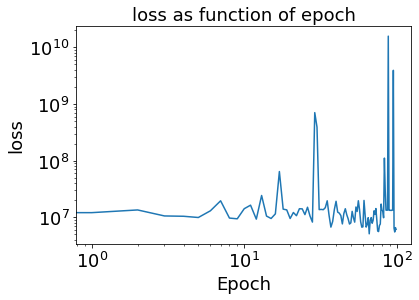

In [30]:
# Test the trained model on fitted data
pl.plot(np.array(history.history['loss']))
pl.yscale('log')
pl.xscale('log')
pl.xlabel('Epoch')
pl.ylabel('loss')
pl.title('loss as function of epoch')

Fig : The figure above shows loss function calculated to train the NN. It shows that the NN is not trained well since a good training will indicate a reduced loss with epoch eventually.

In [33]:
# Due to time constraint, I am using the not so well trained NN model 
# (evident from loss function plot above)
# Bottleneck layer
model.layers[2].output

<tf.Tensor 'bottleneck/Relu:0' shape=(None, 20) dtype=float32>

(11772, 1800)
(11772, 1800)


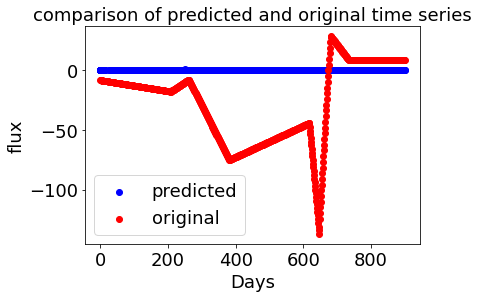

In [43]:
# Compare model output from autoencoder
outim = model.predict(X_te_t)
print(outim.shape)
print(y_te_t.shape)

ob1 = randint(1)
pl.scatter(outim[ob1,0:col_t], outim[ob1, col_t:col_f], color='blue', label='predicted')
pl.scatter(y_te_t[ob1,0:col_t], y_te_t[ob1, col_t:col_f], color='red', label='original')
pl.title('comparison of predicted and original time series')
pl.xlabel('Days')
pl.ylabel('flux')
pl.legend(loc='best')


Fig : One may see clearly that NN is not trained well and hence predicted time series does not match with original time series

In [0]:
from keras import backend as K

# input placeholder
inp = model.input
# Extract bottleneck outputs which are our features
outputs = model.layers[2].output
# Create a function to evaluate the output of the bottleneck for a given input
functors = K.function([inp], [outputs]) 



In [0]:
# Given 1800 features, return 200 features from bottleneck layer from entire data
obs = X_inp_scaled.shape[0] 
dim = X_inp_scaled.shape[1]
# initializing array to save 20 feature data from NN
feature_NN = np.zeros((obs, 20), dtype=float64)
for ii in range(obs):
   # Given 1800 feature data returns 20 feature data for each observations
   layer_outs_2 = functors(X_inp_scaled[ii,:].reshape(1, dim))  
   # Store each obs in array
   # print(layer_outs_2[0].shape)
   feature_NN[ii, :] = layer_outs_2[0]


## Load saved data

In [47]:
feature_data = pd.read_csv('allfeature_saved_Bianco.csv');
feature_data.shape

(7848, 77)

**Checking if there are any missing data**

In [48]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (feature_data.isna().sum().sum()), np.prod(feature_data.shape) - (np.isfinite(feature_data).sum().sum())))


there are 0 NaN and 0 infinity entries


In [49]:
# dropping the observation with infinity
# This is sanity check : if there are any inf value that will be replaced by nan
feature_data.shape, feature_data.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 77), (7848, 77))

In [50]:
# Converting all data into array
# Input data except last column which is "target"
X_data0 = feature_data.iloc[:,1: len(feature_data.columns)-1].values
print(X_data0)
print("Shape of X_data is", X_data0.shape)

[[-3.25455438e+00  8.39447348e+01  6.93486583e+03 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.72039787e+00  7.11350926e+00  4.98791281e+01 ...  1.00000000e+00
   1.62700000e+00  2.55000000e-01]
 [-4.80804167e-02  1.82887215e+00  3.29831814e+00 ...  1.00000000e+00
   2.26000000e-01  1.60000000e-02]
 ...
 [-2.82914231e-01  4.66051866e+01  2.00496316e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.37420779e+00  1.44202011e+01  1.93089185e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.12700937e+02  2.12076651e+03  4.15167747e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Shape of X_data is (7848, 75)


In [51]:
# Converting all data into array
# Output / target data
Y_data = feature_data.iloc[:,-1].values
print(Y_data)
print("Shape of Y_data is", Y_data.shape)

[92 88 42 ... 16 65  6]
Shape of Y_data is (7848,)


## Updated feature dataset once 15 feature data from NN is added to previously calculated scaled feature dataset

In [53]:
# New updated data will now have dimension of 75 + 200 = 90 columns
# Hence X_new will have a shape of (obs, 90) where obs = 7848 (no. of row) 
# Total number of features
dim1 = 75 
obs1 = X_data0.shape[0]
tot_feat = dim1 + int(X_tr_t.shape[1]/(9*10)) 
X_new = np.zeros((obs1, tot_feat ), dtype=float64 )
print('Shape of new dataset', X_new.shape)
print('Total no. of features', tot_feat)

Shape of new dataset (7848, 95)
Total no. of features 95


In [0]:
# Load previous 75 feature data
X_new[:, 0: dim1] = X_data0[:, :] 
# Load new 15 feature data
X_new[:,dim1: tot_feat] = feature_NN[0:obs1, :]

In [55]:
print('New data\n', X_new)

New data
 [[-3.25455438e+00  8.39447348e+01  6.93486583e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.72039787e+00  7.11350926e+00  4.98791281e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.80804167e-02  1.82887215e+00  3.29831814e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-2.82914231e-01  4.66051866e+01  2.00496316e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.37420779e+00  1.44202011e+01  1.93089185e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.12700937e+02  2.12076651e+03  4.15167747e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


# Standardize the data

In [59]:
featuremeans = X_new.mean(axis = 0)
featurestd = X_new.std(axis=0)
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations {}".format(
    *X_new.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays [ 3.92737631e+01  2.18255899e+02  1.17402466e+08  1.17402466e+08
  5.23882191e+02 -2.47707666e+02 -7.30978852e-02  3.24319722e-04
  6.37471557e-03 -3.23450251e+01  8.15494393e-03  2.96187944e+01
  1.88291251e+02  1.26600038e+06  1.26600038e+06  3.87999042e+02
 -1.88841777e+02 -1.58191816e-01 -4.47031168e-03  2.58871203e-02
 -2.76154819e+01 -2.96436596e+01  5.37716616e-02  4.29330082e+01
  2.04791323e+02  3.54331510e+06  3.54331510e+06  4.84962221e+02
 -2.16683247e+02 -2.01574134e-01 -2.48675518e-03  3.19192091e-02
 -3.65387768e+01 -3.96869617e+01  8.53720693e-02  4.42794190e+01
  1.98862866e+02  4.83654718e+06  4.83654718e+06  4.76626366e+02
 -1.95807404e+02 -1.94071059e-01 -1.69153033e-03  2.11262820e-02
 -3.56182235e+01 -3.88739946e+01  6.85524975e-02  3.08623239e+01
  2.04063537e+02  4.46795407e+06  4.46795407e+06  5.38815350e+02
 -2.13475481e+02 -1.69135766e-01  6.93903055e-04 -3.41830907e-03
 -4.34667982e+01 -4.67233499e+01  3.82262997e-02

In [60]:
from sklearn import preprocessing
# Setting mean to zero and dividing by std in preprocessing 
X_scaled = preprocessing.scale(X_new)

print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [ 6.18205227e-17 -2.76317931e-17  5.25920944e-18  5.25920944e-18
 -5.50018746e-17  5.22744596e-17  3.43478785e-17  2.97078026e-17
 -2.65106772e-17 -3.21188030e-15 -3.81733947e-15  2.23798780e-17
  7.09309155e-17 -8.04565599e-18 -8.04565599e-18 -4.08835951e-17
 -5.03264323e-17 -2.83497317e-17  2.52374857e-17  1.67778352e-17
  9.35583585e-16 -1.12905211e-15  1.03077587e-15 -2.98775615e-17
 -8.26159845e-18  3.16069800e-17  3.16069800e-17 -1.31280195e-17
  7.49343955e-17  7.80466415e-17  6.65737711e-17 -3.48288620e-17
  2.61895500e-15  1.05653678e-16  6.00892651e-15  1.04048042e-17
  1.01855323e-18  2.07140085e-17  2.07140085e-17 -2.71048333e-17
  6.68248727e-17  1.10484733e-16 -5.77463097e-17 -3.45176374e-18
  3.29728316e-16  2.32660193e-15 -2.47335848e-15  7.54578187e-17
  4.13079923e-17  1.85956698e-17  1.85956698e-17 -2.91985260e-17
 -2.00403885e-17  7.62924665e-17  6.68849957e-17  1.03227541e-16
  1.61129463e-16 -2.78533284e-

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [61]:
print(X_scaled.mean(axis=0).shape)
print(X_scaled.std(axis=0).shape)


(95,)
(95,)


In [62]:
# Visualize how the standardized data look like 
X_scaled

array([[-0.02011422, -0.01187022, -0.01147233, ...,  0.        ,
        -0.05538498, -0.02656776],
       [-0.01986158, -0.01866044, -0.011473  , ...,  0.        ,
        -0.05538498, -0.02656776],
       [-0.01859768, -0.01912749, -0.011473  , ...,  0.        ,
        -0.05538498, -0.02656776],
       ...,
       [-0.01870875, -0.01517023, -0.01147281, ...,  0.        ,
        -0.05538498, -0.02656776],
       [-0.01697907, -0.01801469, -0.01147299, ...,  0.        ,
        -0.05538498, -0.02656776],
       [ 0.36580053,  0.16814101, -0.01106729, ...,  0.        ,
        -0.05538498, -0.02656776]])

## Classification with randomforest (RF) 

In [63]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_data, 
                                                                test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5886, 95), (1962, 95), (5886,), (1962,))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_train, y_train)



**Measure classification performance using test score**

In [65]:
print("Random Forest Classification of training data \n" + 
       "score on  {:.2f}".format(
           clf.score(X_train, y_train)))

print("Random Forest Classification of test data \n" + 
       "score on  {:.2f}".format(
           clf.score(X_test, y_test)))

Random Forest Classification of training data 
score on  0.65
Random Forest Classification of test data 
score on  0.63


In [0]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test))

np.set_printoptions(precision=2)


Confusion matrix, without normalization
Normalized confusion matrix


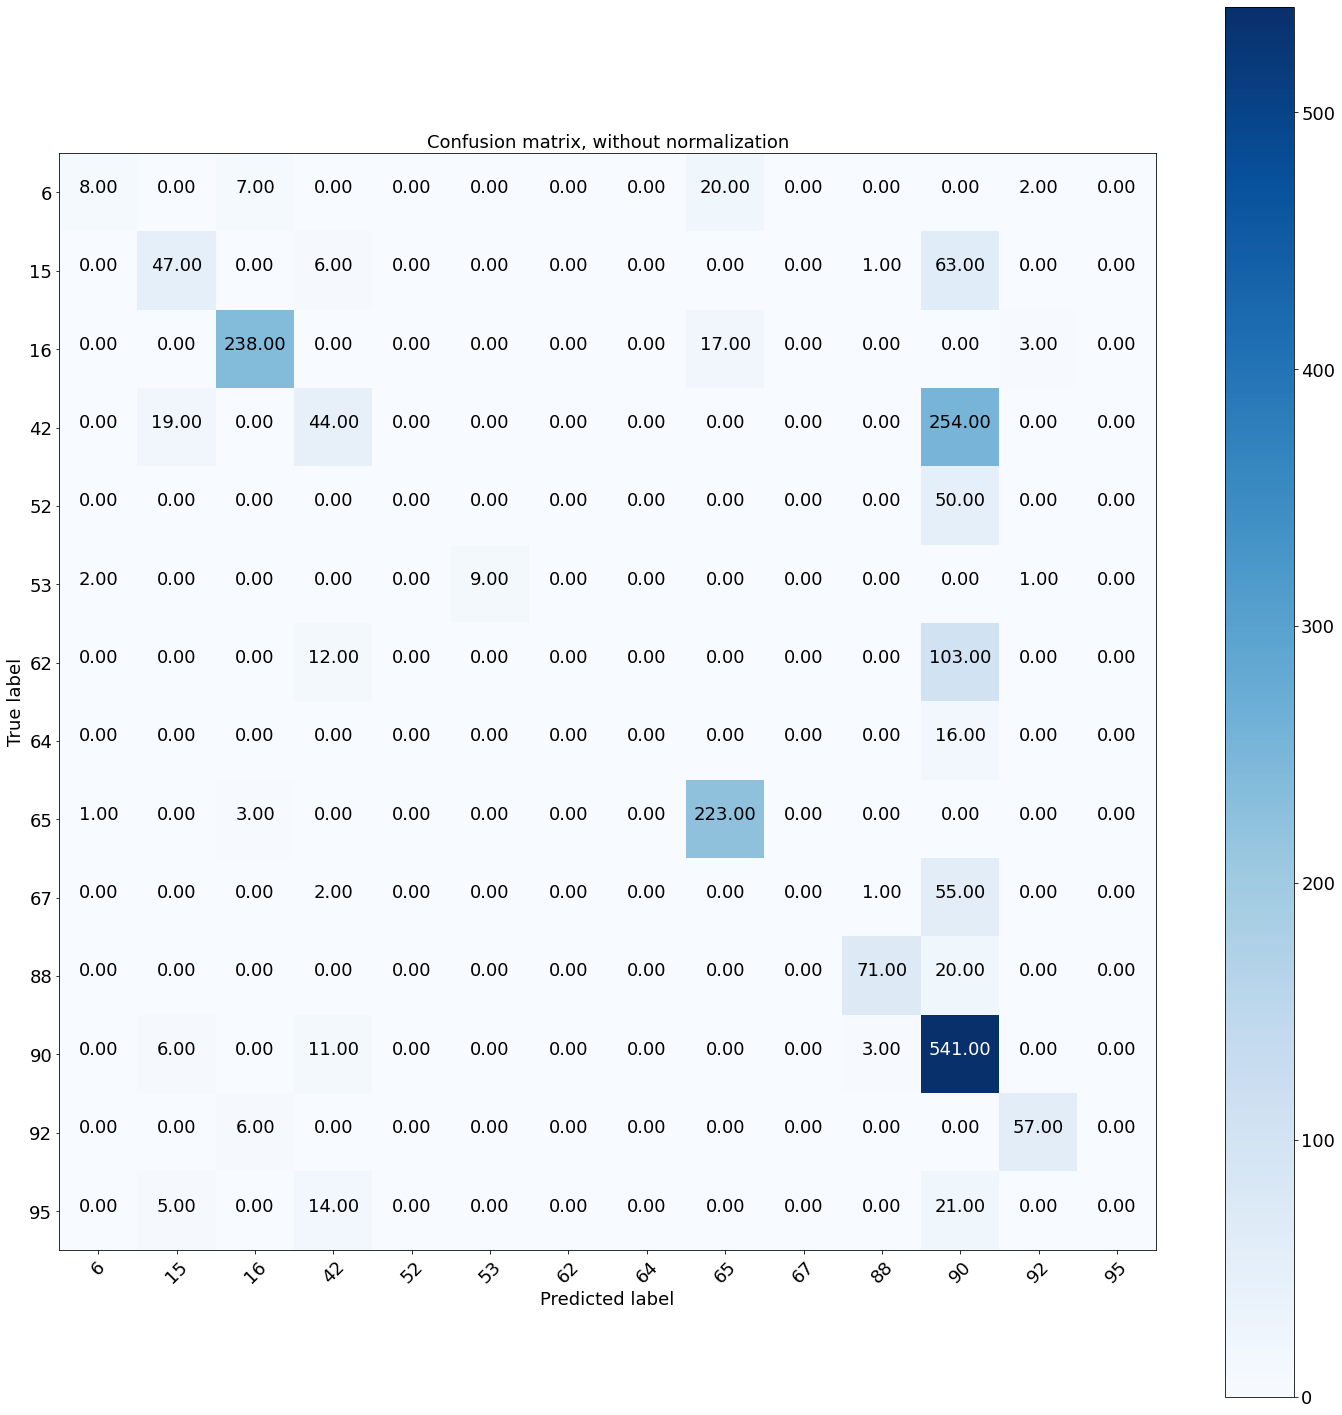

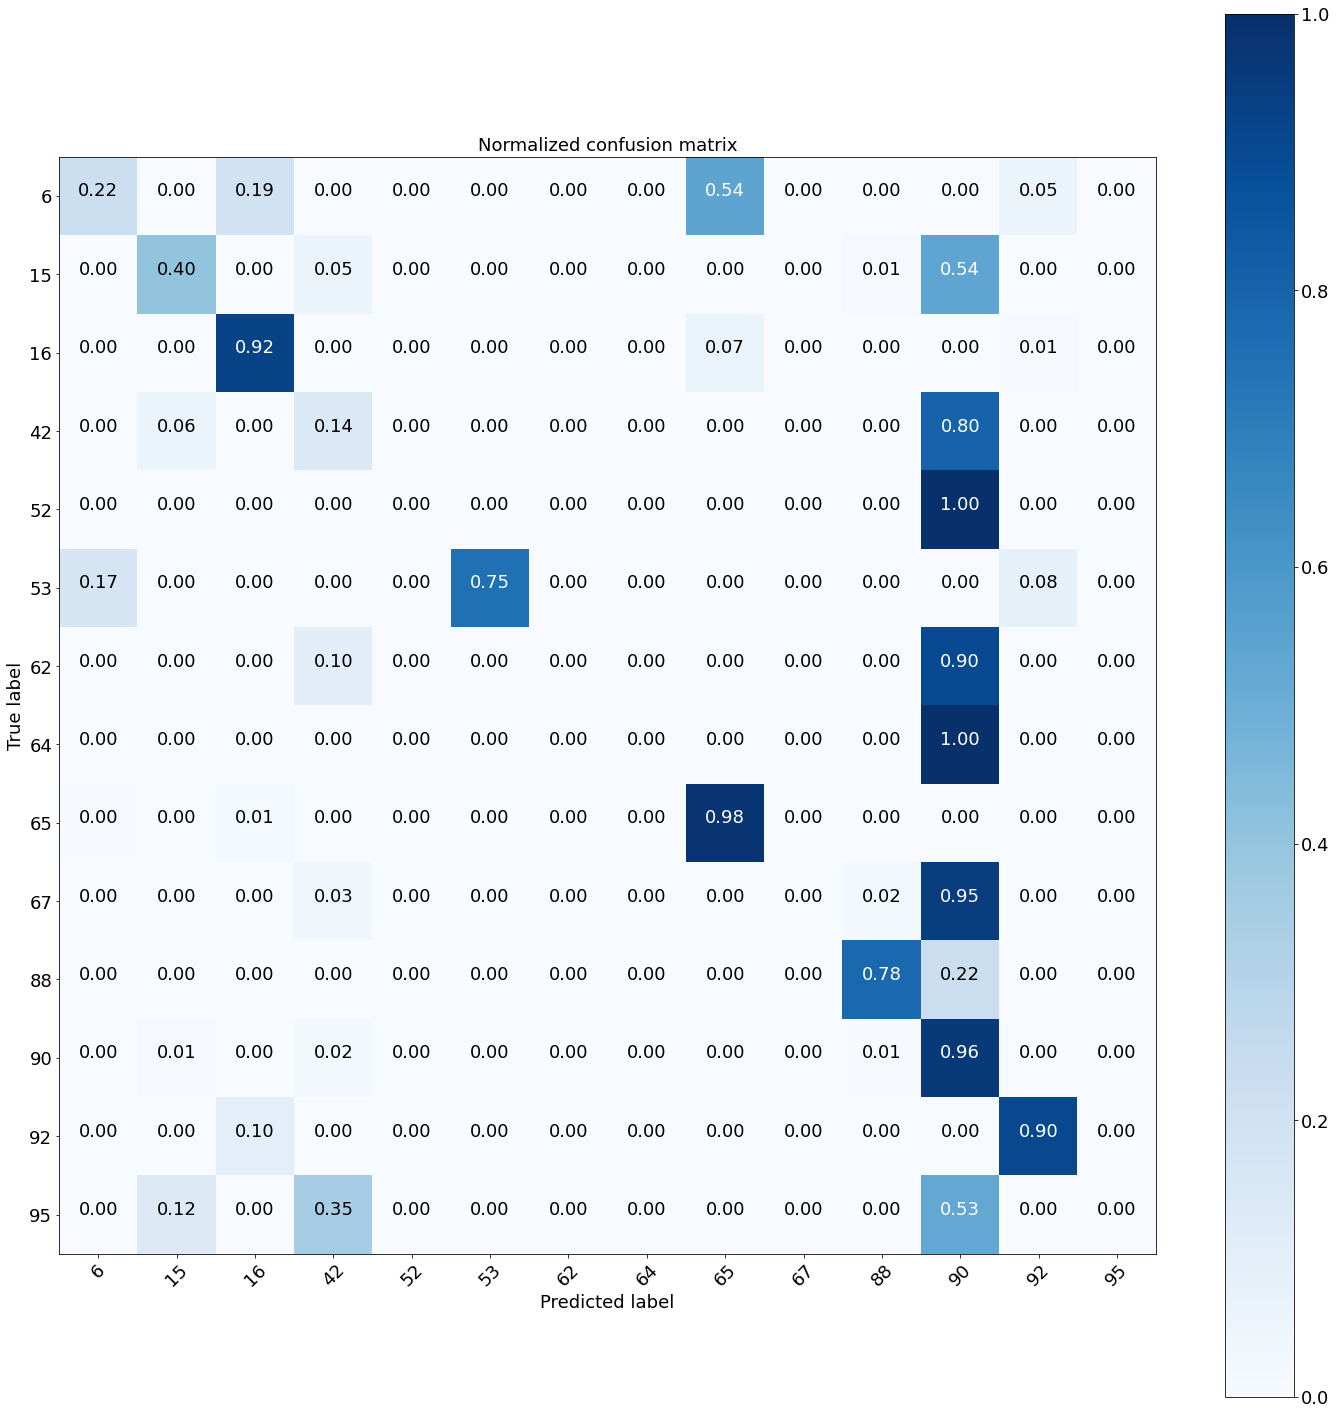

In [69]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(Y_data)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,20))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(Y_data)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Fig : The top figure shows confusion matrix for unnormalized data when new features extracted from autoencoder bottleneck hidden layer is extracted. 
The bottom layer shows the same for normalized data. Some data such as 92 are labelled with 90% accuracy but some are mislabelled such as item 90, 88 with accuracy of 22%.

**Compare result without feature from NN**

In [0]:
# Compare result with feature data without NN features
X_scaled_2 = preprocessing.scale(X_data0)


In [71]:
import sklearn
from sklearn.model_selection import train_test_split

X_train_no_NN, X_test_no_NN, y_train_no_NN, y_test_no_NN = train_test_split(X_scaled_2, Y_data, 
                                                                test_size=0.25)

X_train_no_NN.shape, X_test_no_NN.shape, y_train_no_NN.shape, y_test_no_NN.shape


((5886, 75), (1962, 75), (5886,), (1962,))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_no_NN = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_train_no_NN, y_train_no_NN)


In [73]:
print("Random Forest Classification of training data \n" + 
       "score on  {:.2f}".format(
           clf_no_NN.score(X_train_no_NN, y_train_no_NN)))

print("Random Forest Classification of test data \n" + 
       "score on  {:.2f}".format(
           clf_no_NN.score(X_test_no_NN, y_test_no_NN)))

Random Forest Classification of training data 
score on  0.65
Random Forest Classification of test data 
score on  0.65


In [0]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix_no_NN = sklearn.metrics.confusion_matrix(y_test_no_NN, clf_no_NN.predict(X_test_no_NN))

np.set_printoptions(precision=2)


Confusion matrix, without normalization
Normalized confusion matrix


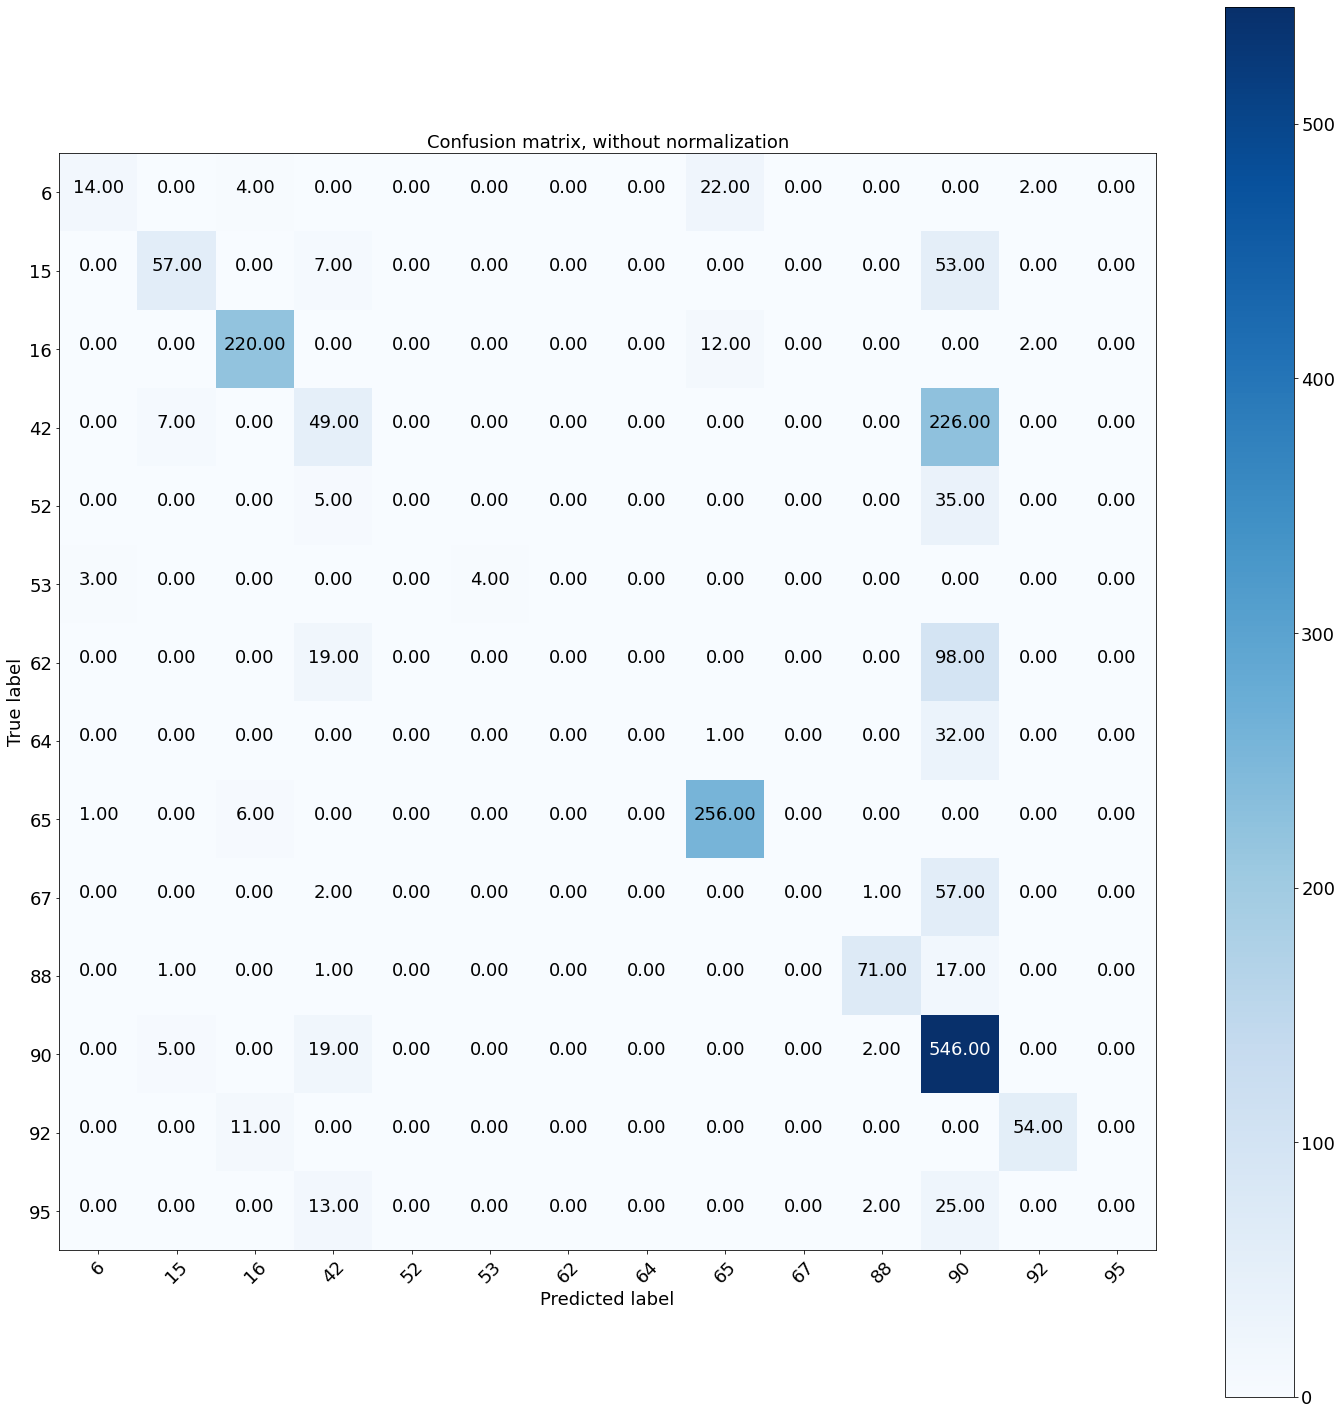

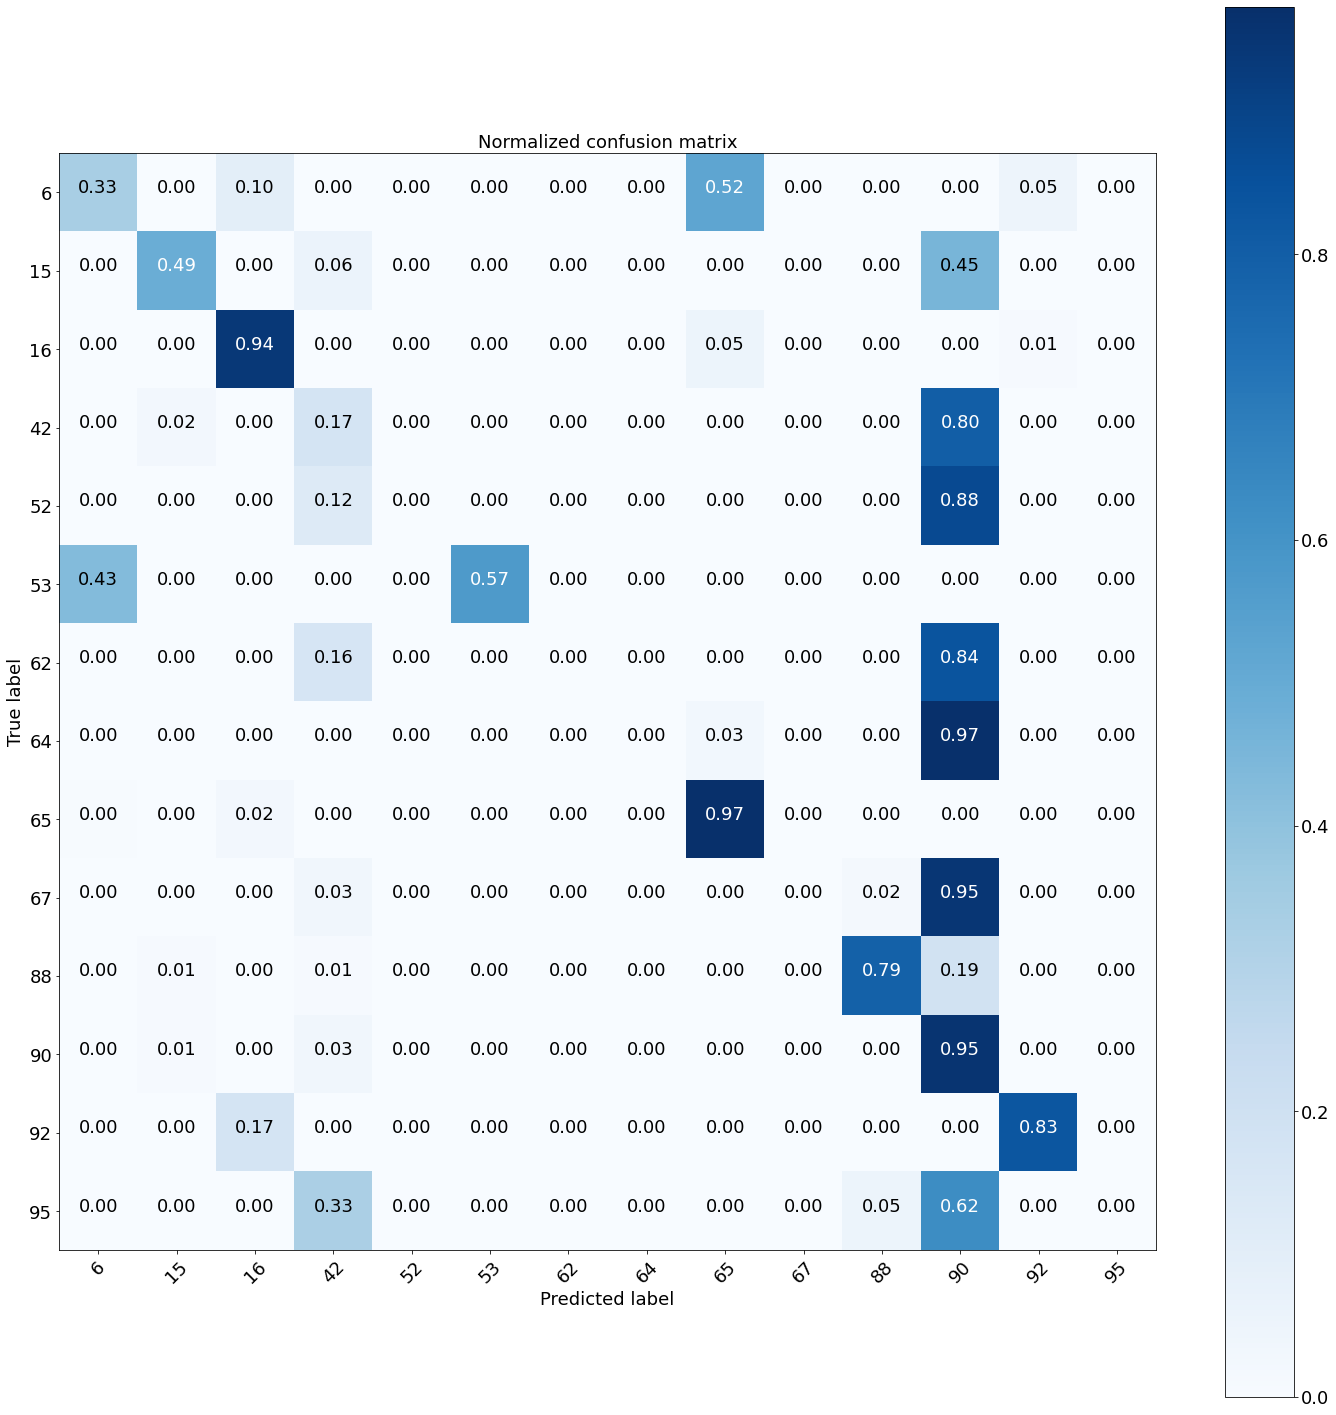

In [75]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))

plot_confusion_matrix(cnf_matrix_no_NN, classes=["%d"%i for i in np.unique(Y_data)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,20))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix_no_NN, classes=["%d"%i for i in np.unique(Y_data)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Fig : The top figure shows confusion matrix for unnormalized data and the bottom one shows the same s=for normalized data. While some of the labels are identified correctly item 90 some are misindetified. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


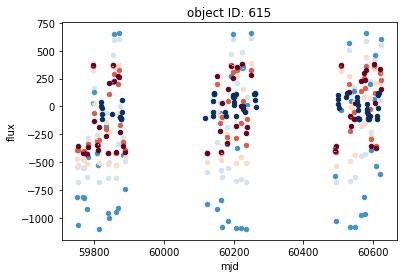

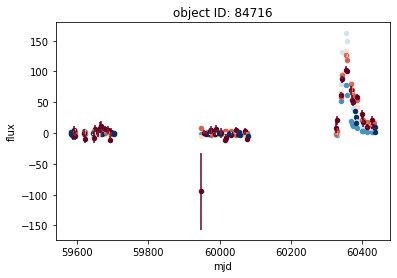

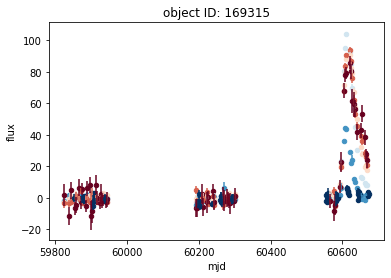

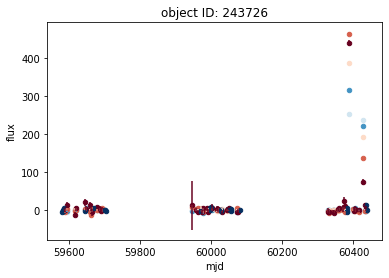

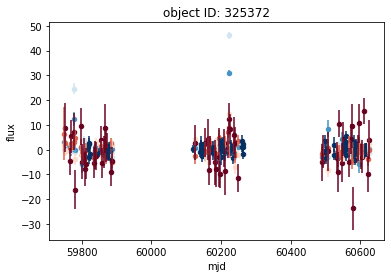

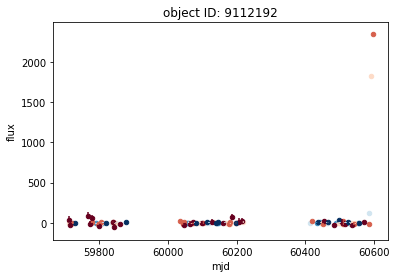

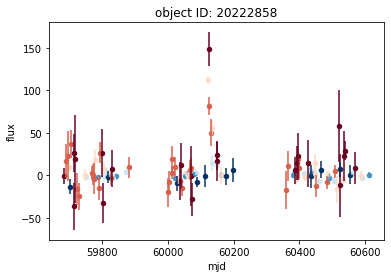

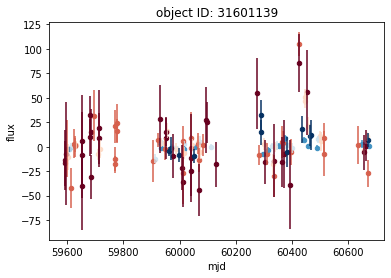

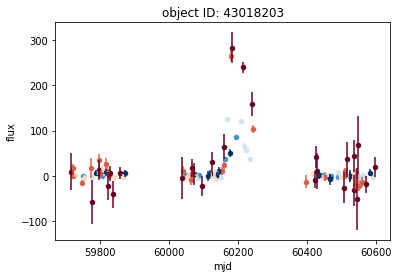

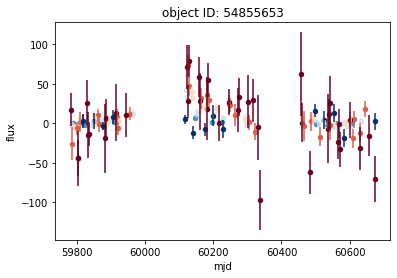

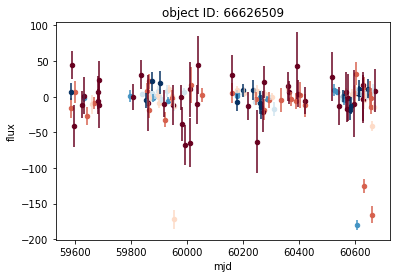

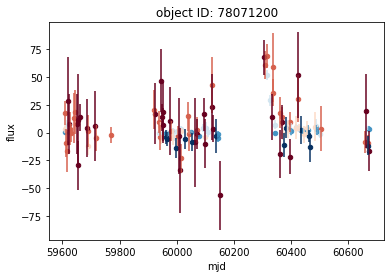

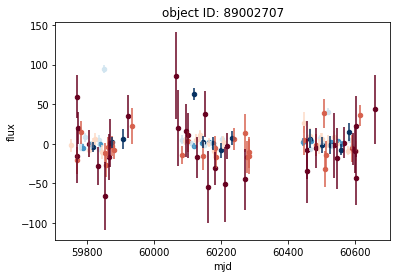

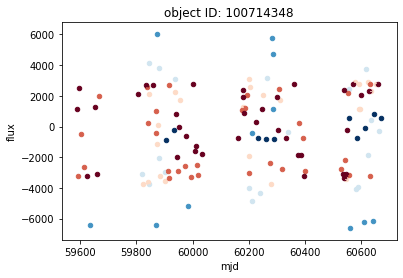

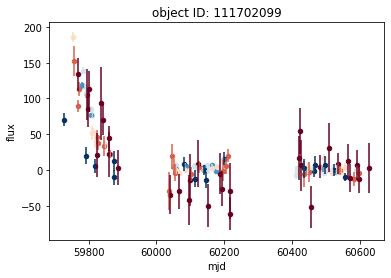

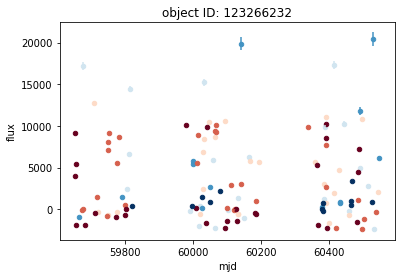

In [142]:
# preparing a normalization to pass to the color map to map red filters to red blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

# -- plot one ever 100o objects
for obj in objects[::500]:
    ax = pl.figure().add_subplot(111)
    for band in bands:
        lcvs[lcvs.object_id == obj][lcvs.passband == band].plot(x="mjd", 
                                            y="flux", yerr="flux_err", ax=ax, kind="scatter", 
                                                                color=pl.cm.RdBu_r(norm_band(band)))
    pl.title("object ID: %d"%obj)  

**Feature extraction**

Get the mean and standard deviation of the flux in each band for each object

In [143]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [0]:
# Get mean nd stds for flux 
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

# Get mean of time "mjd" for each obj and passbands
mjd_m = lcvs.groupby(["object_id", "passband"])[["mjd"]].mean()
mjd_std = lcvs.groupby(["object_id", "passband"])[["mjd"]].std()

In [145]:
means

flux
object_id passband             
615       0           -3.254554
          1         -385.699911
          2         -134.146566
          3         -121.103501
          4          -55.954592
...                         ...
130779836 1          725.169852
          2         2690.360415
          3          755.993902
          4         3489.185336
          5         4151.358875

[47088 rows x 1 columns]

In [146]:
mjd_m

mjd
object_id passband              
615       0         60278.940730
          1         60175.754255
          2         60175.746548
          3         60175.761947
          4         60175.772940
...                          ...
130779836 1         60168.324350
          2         60158.890352
          3         60206.303864
          4         60166.894600
          5         60148.754635

[47088 rows x 1 columns]

In [171]:
features = means.rename({"flux": "mean"}, 
                        axis=1).merge(stds.rename({"flux": "std"}, 
                                axis=1), left_index=True, right_index=True)
                                
features.head()

mean         std
object_id passband                        
615       0          -3.254554   83.944735
          1        -385.699911  601.787302
          2        -134.146566  455.121346
          3        -121.103501  335.425053
          4         -55.954592  291.803449

In [0]:
from scipy import stats 
def m2_get(x):
    return stats.moment(x, moment = 2)
def m3_get(x):
    return stats.moment(x, moment = 3)
    
m2 = lcvs.groupby(["object_id", "passband"])["flux"].apply(m2_get)
m3 = lcvs.groupby(["object_id", "passband"])["flux"].apply(m3_get)


features = features.merge(pd.DataFrame(m2).rename({"flux":"m2"}, axis=1), 
                          left_index=True, right_index=True)
features = features.merge(pd.DataFrame(m2).rename({"flux":"m3"}, axis=1), 
                          left_index=True, right_index=True)

In [0]:
maxs = lcvs.groupby(["object_id", "passband"])["flux"].max()
mins = lcvs.groupby(["object_id", "passband"])["flux"].min()

features = features.merge(pd.DataFrame(maxs).rename({"flux":"maxs"}, axis=1), 
                          left_index=True, right_index=True)
features = features.merge(pd.DataFrame(mins).rename({"flux":"mins"}, axis=1), 
                          left_index=True, right_index=True)

In [0]:
# normalize each LC this is very slow. can you make it faster?
def normed(df):
    obj, band = df.object_id.values[0], df.passband.values[0]
    df["fluxnormed"] = (df["flux"] - means.loc[obj, band].values[0]) / stds.loc[obj, band].values[0]
    return df
    
    
lcvs = lcvs.groupby(["object_id", "passband"]).apply(normed)

In [0]:
maxs_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].max()
mins_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].min()

In [0]:
medians = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()

features = features.merge(pd.DataFrame(medians).rename({"fluxnormed":"median"}, axis=1), 
                          left_index=True, right_index=True)


In [169]:
medians.head()

fluxnormed
object_id passband            
615       0          -0.080537
          1          -0.170090
          2          -0.289021
          3          -0.122434
          4          -0.163078

In [170]:
mjd_m.head()

mjd
object_id passband              
615       0         60278.940730
          1         60175.754255
          2         60175.746548
          3         60175.761947
          4         60175.772940

In [177]:
# Added time of measurement "mjd" averaged for each band for each object

features = features.merge(pd.DataFrame(mjd_m).rename({"mjd":"mjd_mean"}, axis=1), 
                          left_index=True, right_index=True)      
features.head()                    

mean         std  ...    median      mjd_mean
object_id passband                          ...                        
615       0          -3.254554   83.944735  ... -0.080537  60278.940730
          1        -385.699911  601.787302  ... -0.170090  60175.754255
          2        -134.146566  455.121346  ... -0.289021  60175.746548
          3        -121.103501  335.425053  ... -0.122434  60175.761947
          4         -55.954592  291.803449  ... -0.163078  60175.772940

[5 rows x 8 columns]

In [0]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvs.groupby(["object_id", "passband"]).apply(linfit)

In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]

features["slopes"] = slopes
features["intercepts"] = intercepts

Quadratic fit

In [180]:
# this is slow!!
from statsmodels.formula.api import ols
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    mod1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    mod2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = mod2.llf, mod1.llf, np.sign(mod2.params[1])
    return pars
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [0]:
ll1 = [x[0] for x in ols.values[:]]
ll2 = [x[1] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]

features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

In [182]:
features.head()

mean         std  ...        ll2  ll3
object_id passband                          ...                
615       0          -3.254554   83.944735  ... -88.218652 -1.0
          1        -385.699911  601.787302  ... -80.869998 -1.0
          2        -134.146566  455.121346  ... -80.109763 -1.0
          3        -121.103501  335.425053  ... -79.290039 -1.0
          4         -55.954592  291.803449  ... -78.480261 -1.0

[5 rows x 13 columns]

In [183]:
# unstack will do the trick ... 
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])
allfeatures.head()

passband          0                          ...          5                
               mean        std           m2  ...        ll1        ll2  ll3
object_id                                    ...                           
615       -3.254554  83.944735  6934.865833  ... -76.917754 -77.386461 -1.0
713       -2.720398   7.113509    49.879128  ... -65.167686 -65.424297 -1.0
730       -0.048080   1.828872     3.298318  ... -66.518080 -67.853917  1.0
745        1.797523   4.374445    18.869993  ... -64.783463 -77.536999 -1.0
1124       0.660948   2.360084     5.481586  ... -76.526495 -76.666778  1.0

[5 rows x 78 columns]

2. You **must choose a common time frame for all observations**: for example for each *object* choose the timestamps of the first observation and set it to 0. Cound time forward in days from that point. 

**Load metadata**

In [166]:
metadata = pd.read_csv("data/plasticc_train_metadata.csv.gz")
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
metadata.shape

(7848, 26)

Merge metadata features

In [167]:
allfeatures = allfeatures.merge(metadata[["object_id", "decl", "ddf_bool", "hostgal_photoz", 
                                          "hostgal_photoz_err", "target"]], on=['object_id'])#.drop("object_id", axis=1)
allfeatures.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,object_id,"(0, mean)","(0, std)","(0, m2)","(0, m3)","(0, maxs)","(0, mins)","(0, median)","(0, slopes)","(0, intercepts)","(0, ll1)","(0, ll2)","(0, ll3)","(1, mean)","(1, std)","(1, m2)","(1, m3)","(1, maxs)","(1, mins)","(1, median)","(1, slopes)","(1, intercepts)","(1, ll1)","(1, ll2)","(1, ll3)","(2, mean)","(2, std)","(2, m2)","(2, m3)","(2, maxs)","(2, mins)","(2, median)","(2, slopes)","(2, intercepts)","(2, ll1)","(2, ll2)","(2, ll3)","(3, mean)","(3, std)","(3, m2)","(3, m3)","(3, maxs)","(3, mins)","(3, median)","(3, slopes)","(3, intercepts)","(3, ll1)","(3, ll2)","(3, ll3)","(4, mean)","(4, std)","(4, m2)","(4, m3)","(4, maxs)","(4, mins)","(4, median)","(4, slopes)","(4, intercepts)","(4, ll1)","(4, ll2)","(4, ll3)","(5, mean)","(5, std)","(5, m2)","(5, m3)","(5, maxs)","(5, mins)","(5, median)","(5, slopes)","(5, intercepts)","(5, ll1)","(5, ll2)","(5, ll3)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,615,-3.254554,83.944735,6934.865833,6934.865833,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-88.218652,-1.0,-385.699911,601.787302,355904.026224,355904.026224,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,203564.138816,203564.138816,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,-121.103501,335.425053,110570.138947,110570.138947,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,83681.162283,83681.162283,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,85370.493377,85370.493377,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,713,-2.720398,7.113509,49.879128,49.879128,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-49.801325,-1.0,-1.019804,5.712334,32.048070,32.048070,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,32.706748,32.706748,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,-0.986966,6.450413,40.864832,40.864832,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,40.316483,40.316483,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,49.427194,49.427194,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,730,-0.048080,1.828872,3.298318,3.298318,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-101.606902,-1.0,0.141057,1.807229,3.203266,3.203266,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,30.313471,30.313471,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,3.236164,8.191987,65.818099,65.818099,33.572102,-5.435799,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,112.462234,112.462234,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,174.276892,174.276892,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,745,1.797523,4.374445,18.869993,18.869993,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-100.184915,-1.0,5.717394,25.964659,662.124902,662.124902,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1003.075853,1003.075853,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,14.412924,34.967698,1200.905234,1200.905234,203.250702,-4.944036,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,1074.034376,1074.034376,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,10.746138,26.060130,666.782529,666.782529,141.513290,-10.249387,-0.306851,-0.002816,0.076043,-64.783463,-77.536999,-1.0,-45.5867,1,0.281,1.152,90
4,1124,0.660948,2.360084,5.481586,5.481586,5.330927,-6.804703,-0.033864,0.0

In [162]:
mjd_m.head()

mjd
object_id passband              
615       0         60278.940730
          1         60175.754255
          2         60175.746548
          3         60175.761947
          4         60175.772940

In [168]:
allfeatures.shape

(7848, 78)

# Load saved data

In [450]:
%ls *.npy
%ls allfeature_saved.csv
%ls MLTSA2020/allfeature_saved_Bianco.csv
%pwd

faces.npy
ls: cannot access 'allfeature_saved.csv': No such file or directory
ls: cannot access 'MLTSA2020/allfeature_saved_Bianco.csv': No such file or directory


'/content/gdrive/My Drive/MLTSA2020'

In [6]:
feature_data = pd.read_csv('MLTSA2020/allfeature_saved_Bianco.csv');
feature_data.shape

(7848, 77)

Checking if there is any missing data

In [7]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (feature_data.isna().sum().sum()), np.prod(feature_data.shape) - (np.isfinite(feature_data).sum().sum())))


there are 0 NaN and 0 infinity entries


In [8]:
# dropping the observation with infinity
# This is sanity check : if there are any inf value that will be replaced by nan
feature_data.shape, feature_data.replace([np.inf, -np.inf], np.nan).dropna().shape

((7848, 77), (7848, 77))

In [9]:
feature_data.head()

,Unnamed: 0,"(0, 'mean')","(0, 'std')","(0, 'm2')","(0, 'm3')","(0, 'maxs')","(0, 'mins')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll1')","(0, 'll3')","(1, 'mean')","(1, 'std')","(1, 'm2')","(1, 'm3')","(1, 'maxs')","(1, 'mins')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll1')","(1, 'll2')","(1, 'll3')","(2, 'mean')","(2, 'std')","(2, 'm2')","(2, 'm3')","(2, 'maxs')","(2, 'mins')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll1')","(2, 'll2')","(2, 'll3')","(3, 'mean')","(3, 'std')","(3, 'm2')","(3, 'm3')","(3, 'maxs')","(3, 'mins')","(3, 'median')","(3, 'slopes')","(3, 'intercepts')","(3, 'll1')","(3, 'll2')","(3, 'll3')","(4, 'mean')","(4, 'std')","(4, 'm2')","(4, 'm3')","(4, 'maxs')","(4, 'mins')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll1')","(4, 'll2')","(4, 'll3')","(5, 'mean')","(5, 'std')","(5, 'm2')","(5, 'm3')","(5, 'maxs')","(5, 'mins')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll1')","(5, 'll2')","(5, 'll3')",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,0,-3.254554,83.944735,6934.865833,6934.865833,125.182808,-116.913223,-0.080537,0.005676,-0.175947,-84.013092,-1.0,-385.699911,601.787302,355904.026224,355904.026224,660.626343,-1100.440063,-0.170090,0.014032,-0.399902,-80.867915,-80.869998,-1.0,-134.146566,455.121346,203564.138816,203564.138816,611.984558,-681.858887,-0.289021,0.017676,-0.503760,-80.092803,-80.109763,-1.0,-121.103501,335.425053,110570.138947,110570.138947,445.737061,-530.644592,-0.122434,0.020475,-0.583524,-79.226482,-79.290039,-1.0,-55.954592,291.803449,83681.162283,83681.162283,381.953735,-422.184509,-0.163078,0.022343,-0.636786,-78.160027,-78.480261,-1.0,-47.449847,294.779522,85370.493377,85370.493377,378.188141,-422.815094,-0.129163,0.021319,-0.596932,-76.917754,-77.386461,-1.0,-61.9438,1,0.000,0.000,92
1,1,-2.720398,7.113509,49.879128,49.879128,14.509829,-14.735178,-0.052914,-0.041433,1.429423,-45.801483,-1.0,-1.019804,5.712334,32.048070,32.048070,9.129021,-11.715749,0.080189,-0.051648,1.420320,-36.052358,-38.161170,-1.0,-0.794238,5.770738,32.706748,32.706748,10.529041,-10.067919,0.117188,-0.053887,1.481892,-34.410798,-35.611095,-1.0,-0.986966,6.450413,40.864832,40.864832,11.330316,-12.394593,0.141552,-0.050983,1.402038,-38.701863,-41.302700,-1.0,-0.900262,6.406989,40.316483,40.316483,9.827934,-12.286801,0.016870,-0.050464,1.387765,-44.424807,-44.870314,-1.0,-1.794175,7.094073,49.427194,49.427194,14.770886,-14.211164,-0.094281,-0.037903,1.042343,-65.167686,-65.424297,-1.0,-27.7844,1,1.627,0.255,88
2,2,-0.048080,1.828872,3.298318,3.298318,5.942166,-3.459960,0.039463,-0.001798,0.063840,-101.249926,-1.0,0.141057,1.807229,3.203266,3.203266,5.693109,-3.393080,0.016754,0.003167,-0.080770,-72.910038,-73.012277,-1.0,2.400870,5.559483,30.313471,30.313471,20.994711,-2.848838,-0.343392,0.026905,-0.686084,-63.777334,-65.193298,1.0,3.236164,8.191987,65.818099,65.818099,33.572102,-5.435799,-0.314425,0.024491,-0.624531,-66.369632,-66.683538,1.0,4.308728,10.710344,112.462234,112.462234,41.159981,-5.836310,-0.308522,0.022552,-0.563811,-65.239486,-66.161110,1.0,4.539396,13.332758,174.276892,174.276892,47.310059,-19.159811,-0.149763,0.019612,-0.490299,-66.518080,-67.853917,1.0,-6.5796,1,0.226,0.016,42
3,3,1.797523,4.374445,18.869993,18.869993,18.014029,-3.874349,-0.169349,-0.013089,0.464675,-88.423048,-1.0,5.717394,25.964659,662.124902,662.124902,192.244293,-3.618410,-0.185994,-0.003826,0.105205,-76.313623,-78.932796,-1.0,9.711532,31.957997,1003.075853,1003.075853,220.795212,-2.159753,-0.290606,-0.003878,0.106641,-72.846380,-78.938052,-1.0,14.412924,34.967698,1200.905234,1200.905234,203.250702,-4.944036,-0.373246,-0.003931,0.108112,-67.105516,-78.945375,-1.0,13.134436,33.069053,1074.034376,1074.034376,183.633118,-15.494463,-0.358773,-0.004774,0.131296,-67.067827,-78.924149,-1.0,10.746138,26.060130,666.782529,666.782529,141.513290,-10.249387,-0.306851,-0.002816,0.076043,-64.783463,-77.536999,-1.0,-45.5867,1,0.281,1.152,

In [10]:
# Converting all data into array
# Input data except last column which is "target"
X_data = feature_data.iloc[:,1: len(feature_data.columns)-1].values
print(X_data)
print("Shape of X_data is", X_data.shape)

[[-3.25455438e+00  8.39447348e+01  6.93486583e+03 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.72039787e+00  7.11350926e+00  4.98791281e+01 ...  1.00000000e+00
   1.62700000e+00  2.55000000e-01]
 [-4.80804167e-02  1.82887215e+00  3.29831814e+00 ...  1.00000000e+00
   2.26000000e-01  1.60000000e-02]
 ...
 [-2.82914231e-01  4.66051866e+01  2.00496316e+03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.37420779e+00  1.44202011e+01  1.93089185e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.12700937e+02  2.12076651e+03  4.15167747e+06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Shape of X_data is (7848, 75)


In [118]:

# Converting all data into array
# Output / target data
Y_data = feature_data.iloc[:,-1].values
print(Y_data)
print("Shape of Y_data is", Y_data.shape)


[92 88 42 ... 16 65  6]
Shape of Y_data is (7848,)


## Standardize the data 

In [11]:
featuremeans = X_data.mean(axis = 0)
featurestd = X_data.std(axis=0)
print("saved means and standard deviation arrays", featuremeans, featurestd)
print("number of observcations {}, features {}, means {}, standard deviations {}".format(
    *X_data.shape, featuremeans.shape[0], featurestd.shape[0]))

saved means and standard deviation arrays [ 3.92737631e+01  2.18255899e+02  1.17402466e+08  1.17402466e+08
  5.23882191e+02 -2.47707666e+02 -7.30978852e-02  3.24319722e-04
  6.37471557e-03 -3.23450251e+01  8.15494393e-03  2.96187944e+01
  1.88291251e+02  1.26600038e+06  1.26600038e+06  3.87999042e+02
 -1.88841777e+02 -1.58191816e-01 -4.47031168e-03  2.58871203e-02
 -2.76154819e+01 -2.96436596e+01  5.37716616e-02  4.29330082e+01
  2.04791323e+02  3.54331510e+06  3.54331510e+06  4.84962221e+02
 -2.16683247e+02 -2.01574134e-01 -2.48675518e-03  3.19192091e-02
 -3.65387768e+01 -3.96869617e+01  8.53720693e-02  4.42794190e+01
  1.98862866e+02  4.83654718e+06  4.83654718e+06  4.76626366e+02
 -1.95807404e+02 -1.94071059e-01 -1.69153033e-03  2.11262820e-02
 -3.56182235e+01 -3.88739946e+01  6.85524975e-02  3.08623239e+01
  2.04063537e+02  4.46795407e+06  4.46795407e+06  5.38815350e+02
 -2.13475481e+02 -1.69135766e-01  6.93903055e-04 -3.41830907e-03
 -4.34667982e+01 -4.67233499e+01  3.82262997e-02

In [12]:
from sklearn import preprocessing
# Setting mean to zero and dividing by std in preprocessing 
X_scaled = preprocessing.scale(X_data)

print("scaled training data feature mean and standard deviations: ", 
      X_scaled.mean(axis=0), X_scaled.std(axis=0))



scaled training data feature mean and standard deviations:  [ 2.71614196e-18  2.71614196e-18  2.71614196e-18  2.71614196e-18
  5.43228391e-18 -1.81076130e-18  1.44860904e-17  1.44860904e-17
  1.81076130e-18  1.15888723e-16  6.51874070e-17  8.60111619e-18
 -2.94248712e-18 -3.62152261e-18 -3.62152261e-18 -9.95918717e-18
  1.35807098e-17 -8.69165426e-17 -2.35398970e-17 -9.05380652e-18
 -1.15888723e-16 -1.15888723e-16 -2.53506583e-17 -2.71614196e-18
 -5.77180166e-18 -1.81076130e-18 -1.81076130e-18  1.04118775e-17
  1.81076130e-18  7.24304522e-18  1.26753291e-17  1.81076130e-18
 -2.89721809e-16 -4.63554894e-16  8.32950200e-17 -4.52690326e-18
 -5.43228391e-18 -9.05380652e-19 -9.05380652e-19  2.26345163e-18
 -1.26753291e-17 -7.24304522e-17 -1.85603034e-17  1.35807098e-18
  1.73833085e-16 -2.31777447e-16  7.24304522e-18 -9.05380652e-19
  3.16883228e-18  1.81076130e-18  1.81076130e-18 -1.49387808e-17
  1.99183743e-17  4.34582713e-17  1.62968517e-17 -3.44044648e-17
  0.00000000e+00  4.63554894e-

In [13]:
print(X_scaled.mean(axis=0).shape)
print(X_scaled.std(axis=0).shape)

(75,)
(75,)


In [14]:
# Visualize how the scaled data look like 
X_scaled

array([[-0.02011422, -0.01187022, -0.01147233, ...,  1.64586898,
        -0.65604749, -0.5184008 ],
       [-0.01986158, -0.01866044, -0.011473  , ...,  1.64586898,
         2.32646766,  0.33062244],
       [-0.01859768, -0.01912749, -0.011473  , ...,  1.64586898,
        -0.24175836, -0.46512875],
       ...,
       [-0.01870875, -0.01517023, -0.01147281, ..., -0.60758178,
        -0.65604749, -0.5184008 ],
       [-0.01697907, -0.01801469, -0.01147299, ..., -0.60758178,
        -0.65604749, -0.5184008 ],
       [ 0.36580053,  0.16814101, -0.01106729, ..., -0.60758178,
        -0.65604749, -0.5184008 ]])

## Split the data into train and test set

In [0]:
# Create train and test data 
SUPERRESOLVE = True
from sklearn.model_selection import train_test_split
if SUPERRESOLVE:
  X_tr,  X_te, y_tr, y_te = train_test_split(X_scaled, X_scaled, 
                                             test_size = .25, random_state=1)  
else:
  X_tr,  X_te, y_tr, y_te = train_test_split(X_scaled, X_scaled, 
                                             test_size = .25, random_state=1)
  

In [16]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((5886, 75), (1962, 75), (5886, 75), (1962, 75))

In [17]:
print(X_tr.shape[1])
print(floor(X_tr.shape[1]/5))
print(floor(X_tr.shape[1]/(5*3)))

75
15.0
5.0


## Build an autoencoder model

In [0]:

def create_model(bottleneck= int(X_tr.shape[1]/(5)), 
                             input_dim=int(X_tr.shape[1])):
  model = Sequential()
  nd1 = int(X_tr.shape[1]/5)
  nd2 = nd1 # int(nd1/3)
  model.add(Dense(nd1, activation='relu', input_dim=int(X_tr.shape[1]), 
                                                         name="bottleneck"))
  # model.add(Dense(nd2, activation='relu', name="bottleneck"))
  if bottleneck < nd2:
    model.add(Dense(bottleneck, activation='relu'))
    model.add(Dense(nd2, activation='relu'))
  # model.add(Dense(nd1, activation='relu'))
  model.add(Dense(int(X_tr.shape[1]), activation='relu'))
  # model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")
  return model
model = create_model()

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck (Dense)           (None, 15)                1140      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                1200      
Total params: 2,340
Trainable params: 2,340
Non-trainable params: 0
_________________________________________________________________


In [20]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, epochs=100, batch_size=10, verbose=1)
# model.save("imgreconstruct_100000.h5")

Epoch 1/100
5886/5886 [==============================] - 1s 150us/step - loss: 1.0701 - mae: 0.4612 - acc: 0.1945
Epoch 2/100
5886/5886 [==============================] - 1s 108us/step - loss: 0.9997 - mae: 0.4222 - acc: 0.2572
Epoch 3/100
5886/5886 [==============================] - 1s 107us/step - loss: 0.9660 - mae: 0.4067 - acc: 0.2815
Epoch 4/100
5886/5886 [==============================] - 1s 111us/step - loss: 0.9432 - mae: 0.3971 - acc: 0.3005
Epoch 5/100
5886/5886 [==============================] - 1s 106us/step - loss: 0.9248 - mae: 0.3903 - acc: 0.3034
Epoch 6/100
5886/5886 [==============================] - 1s 107us/step - loss: 0.9093 - mae: 0.3854 - acc: 0.3187
Epoch 7/100
5886/5886 [==============================] - 1s 101us/step - loss: 0.8958 - mae: 0.3809 - acc: 0.3379
Epoch 8/100
5886/5886 [==============================] - 1s 100us/step - loss: 0.8835 - mae: 0.3767 - acc: 0.3569
Epoch 9/100
5886/5886 [==============================] - 1s 101us/step - loss: 0.8710 - 

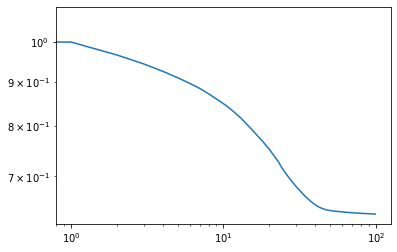

In [21]:
# Test the trained model on fitted data
pl.plot(np.array(history.history['loss']))
pl.yscale('log')
pl.xscale('log')


In [22]:

outim = model.predict(X_te)
outim

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.5883993 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.47441262],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.2442613 ]], dtype=float32)

# Predict

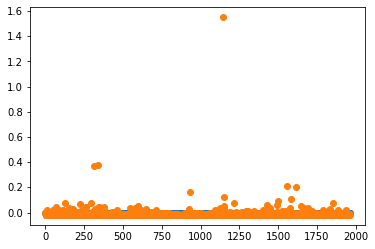

In [26]:
xx = np.arange(len(outim[:,1]))
pl.scatter(xx, outim[:,1])

pl.scatter(xx, y_te[:,1])


In [0]:
output_image = model_digits.predict(x_test)

for i in range(10):
  compareinout(i, output_image, x_test)
  

# Extract bottlenect layer parameters as features

In [0]:

outim = model.predict(X_te)
outim

from keras import backend as K

# input placeholder
inp = model.input
# Extract bottleneck outputs which are our features
outputs = model.layers[0].output
# Create a function to evaluate the output of the bottleneck for a given input
functors = K.function([inp], [outputs]) 

# Testing
layer_outs = functors(X_te[:1])  # First set of observations on all 75 features
layer_outs[0]
pl.scatter(np.arange(layer_outs[0].shape[1]), layer_outs[0], color='blue')


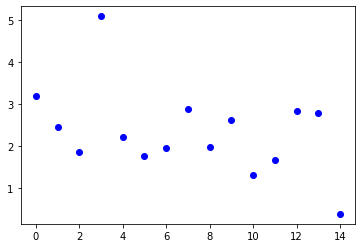

In [73]:
# Testing
layer_outs = functors(X_te[:1])  # First set of observations on all 75 features
layer_outs[0]
pl.scatter(np.arange(layer_outs[0].shape[1]), layer_outs[0], color='blue')

Fig. 15 features for first set of observations extracted from bottleneck of autoencoder

Add title, labels ????

In [76]:
# extract all 15 feature parameters from bottleneck layer
print(X_scaled.shape)
print(X_scaled[1,:].shape)
print(X_te[:1].shape)
print(X_scaled[0,:].reshape(1,75).shape)

(7848, 75)
(75,)
(1, 75)
(1, 75)


In [0]:
# Given 75 features, return 15 features from bottleneck layer from entire data
obs = X_scaled.shape[0] 
dim = X_scaled.shape[1]
# initializing array to save 15 feature data from NN
feature_NN = np.zeros((obs, int(X_tr.shape[1]/(5)) ), dtype=float64)
for ii in range(obs):
   # Given 75 feature data returns 15 feature data for each observations
   layer_outs_2 = functors(X_scaled[ii,:].reshape(1, dim))  
   # Store each obs in array
   # print(layer_outs_2[0].shape)
   feature_NN[ii, :] = layer_outs_2[0]


In [92]:
feature_NN.shape

(7848, 15)

# Updated feature dataset once 15 feature data from NN is added to previously calculated scaled feature dataset

In [109]:
# New updated data will now have dimension of 75 + 15 = 90 columns
# Hence X_new will have a shape of (obs, 90) where obs = 7848 (no. of row) 
# Total number of features
tot_feat = dim + int(X_tr.shape[1]/(5)) 
X_new = np.zeros((obs, tot_feat ), dtype=float64 )
print('Shape of new dataset', X_new.shape)
print('Total no. of features', tot_feat)

Shape of new dataset (7848, 90)
Total no. of features 90


In [0]:
# Load previous 75 feature data
X_new[:, 0: dim] = X_scaled[:, :] 
# Load new 15 feature data
X_new[:,dim: tot_feat] = feature_NN[:, :]

In [117]:
print('New data\n', X_new)

New data
 [[-0.02011422 -0.01187022 -0.01147233 ...  1.04951     0.
   0.68459797]
 [-0.01986158 -0.01866044 -0.011473   ...  1.61735523  0.32841253
   2.15544438]
 [-0.01859768 -0.01912749 -0.011473   ...  1.43423319  0.
   1.45665753]
 ...
 [-0.01870875 -0.01517023 -0.01147281 ...  1.0684036   1.515522
   2.88868403]
 [-0.01697907 -0.01801469 -0.01147299 ...  0.14779353  0.9303357
   1.22644949]
 [ 0.36580053  0.16814101 -0.01106729 ...  4.18330765  6.26294088
   1.04502416]]


## Classification with randomforest (RF) 

**Create test and trainign dataset**

In [119]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, Y_data, 
                                                                test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((5886, 90), (1962, 90), (5886,), (1962,))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_train, y_train)



**Measure classification performance using test score**

In [131]:
print("Random Forest Classification of training data \n" + 
       "score on  {:.2f}".format(
           clf.score(X_train, y_train)))

print("Random Forest Classification of test data \n" + 
       "score on  {:.2f}".format(
           clf.score(X_test, y_test)))

Random Forest Classification of training data 
score on  0.66
Random Forest Classification of test data 
score on  0.63


???? Comment

**Confusion matrix**

In [124]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test))

np.set_printoptions(precision=2)


'\n# Plot non-normalized confusion matrix\nplt.figure(figsize=(10,10))\n\nplot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)],\n                      title=\'Confusion matrix, without normalization\')\n\n# Plot normalized confusion matrix\nplt.figure(figsize=(10,10))\nnp.set_printoptions(precision=2)\nplot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y)], normalize=True,\n                      title=\'Normalized confusion matrix\')\n\nplt.show()\n\n'

Confusion matrix, without normalization
Normalized confusion matrix


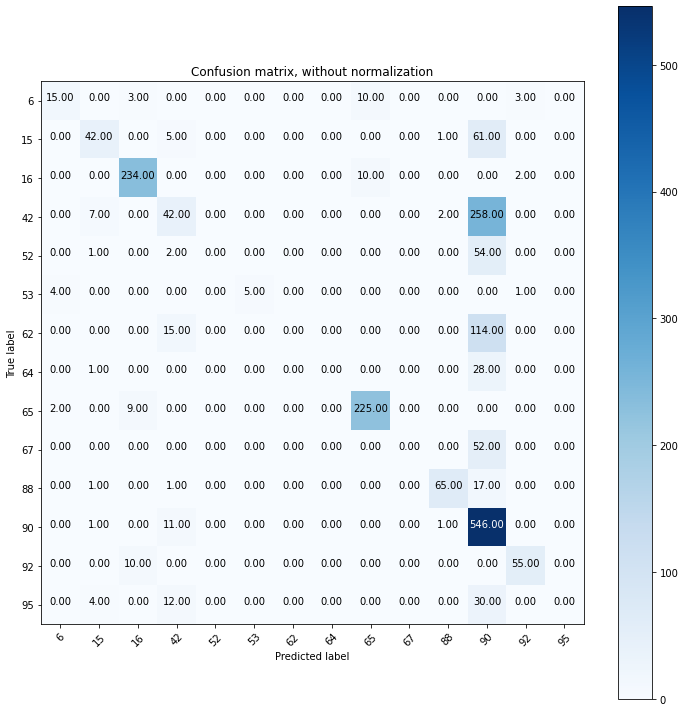

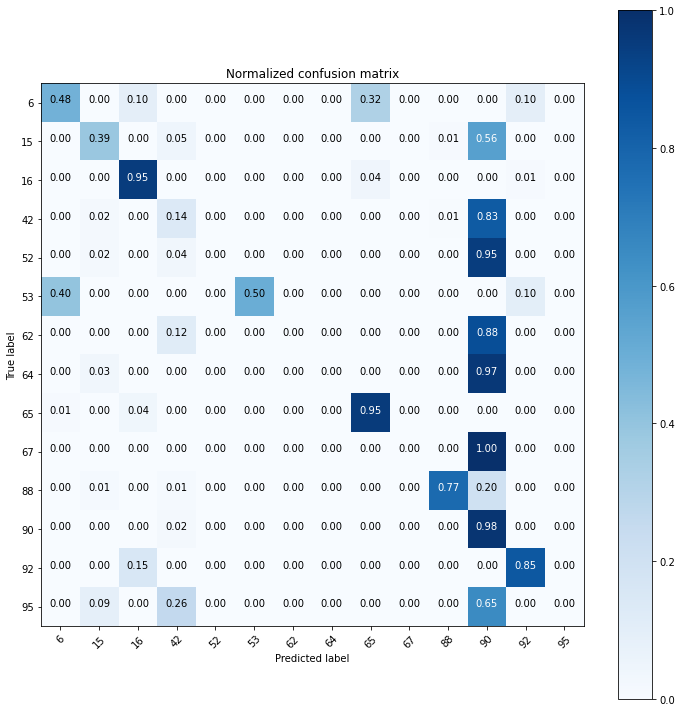

In [127]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(Y_data)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(Y_data)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Compare result without feature from NN




In [128]:
import sklearn
from sklearn.model_selection import train_test_split

X_train_no_NN, X_test_no_NN, y_train_no_NN, y_test_no_NN = train_test_split(X_scaled, Y_data, 
                                                                test_size=0.25)

X_train_no_NN.shape, X_test_no_NN.shape, y_train_no_NN.shape, y_test_no_NN.shape


((5886, 75), (1962, 75), (5886,), (1962,))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf_no_NN = RandomForestClassifier(n_estimators=100, 
                        criterion='gini', max_depth=5).fit(X_train_no_NN, y_train_no_NN)


**Measure score without NN features**

In [132]:
print("Random Forest Classification of training data \n" + 
       "score on  {:.2f}".format(
           clf_no_NN.score(X_train_no_NN, y_train_no_NN)))

print("Random Forest Classification of test data \n" + 
       "score on  {:.2f}".format(
           clf_no_NN.score(X_test_no_NN, y_test_no_NN)))

Random Forest Classification of training data 
score on  0.66
Random Forest Classification of test data 
score on  0.65


In [0]:
#https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix_no_NN = sklearn.metrics.confusion_matrix(y_test_no_NN, clf_no_NN.predict(X_test_no_NN))

np.set_printoptions(precision=2)


Confusion matrix, without normalization
Normalized confusion matrix


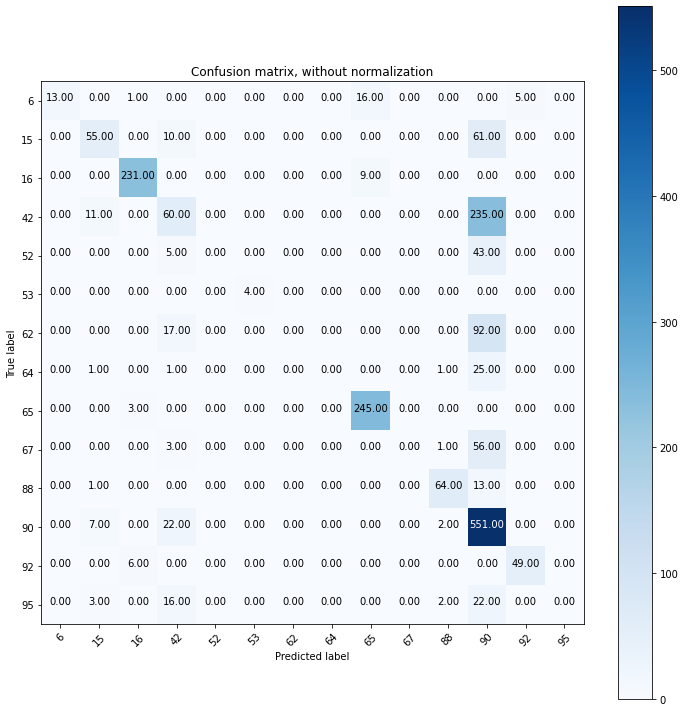

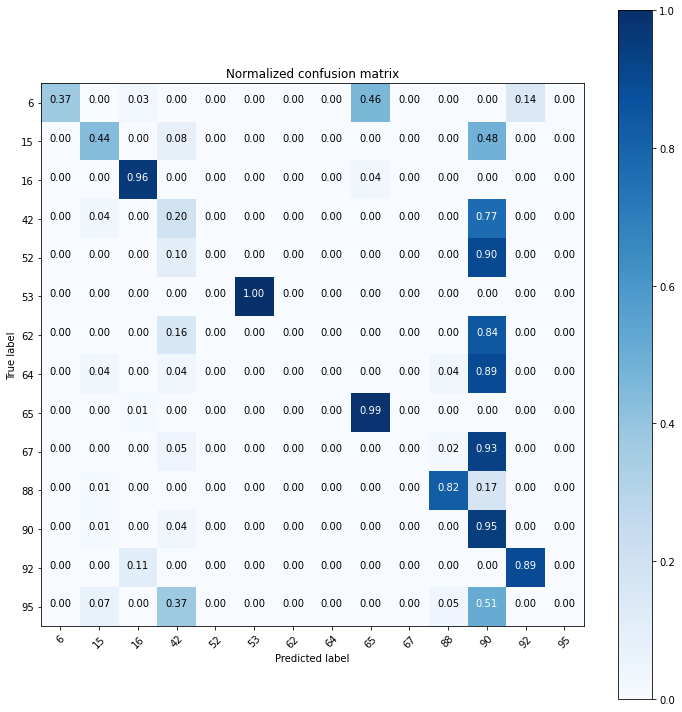

In [135]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))

plot_confusion_matrix(cnf_matrix_no_NN, classes=["%d"%i for i in np.unique(Y_data)],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix_no_NN, classes=["%d"%i for i in np.unique(Y_data)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()